In [2]:
import os, sys, glob
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
# from tqdm.notebook import tqdm

from tqdm import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj, load_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    PerspectiveCameras,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)
from PIL import Image

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from pytorch3d.io import load_obj, load_ply
from pytorch3d.renderer import RasterizationSettings, PointLights, MeshRenderer, MeshRasterizer, TexturesVertex, SoftPhongShader, SfMPerspectiveCameras, PerspectiveCameras, BlendParams, FoVPerspectiveCameras, FoVOrthographicCameras
from pytorch3d.structures import Meshes

In [4]:
path = './data/john-oliver-SHOW1/jo1_fullbody_rot180'
files = glob.glob(path + '/*')
files.sort()
print(len(files))
meshes = []
for i in tqdm(range(n_train)):
    verts1, faces1, _ = load_obj(files[i], device=device)
    V = verts1.shape[0]
    verts_rgb = torch.from_numpy(np.array([0.5, 0.5, 0.5])).float()[None, None, :].repeat(1,V,1)
    textures = TexturesVertex(verts_features=verts_rgb,).to(device)
    mesh = Meshes(verts=verts1[None], faces=faces1.verts_idx[None], textures=textures,).to(device)
    meshes.append(mesh)

30330


In [15]:
from plot_image_grid import image_grid

In [16]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
obj_filename = os.path.join('./data/jhon_oliver/meshes/00000.obj')

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

In [17]:
print(mesh.verts_packed().shape)
print(mesh.verts_list()[0].shape)

torch.Size([8465, 3])
torch.Size([8465, 3])


In [18]:
def set_pytorch3D():
    # print(transl[0])#[-0.19163294 -0.7803175   5.7486043 ]
    n_frame = 1
    #transl = transl_list[0]
    #transl[:,1] *= -1
    R = np.array([[[-1,0,0],[0,1,0],[0,0,-1]]]).repeat(n_frame, 0)
    T = np.array([[-0.19163294, -0.7803175, 5.7486043 ]])
    fl = np.array([[19.53125]]).repeat(n_frame, 0) #depends on z_near and z_far
    pp = np.array([[0.75, -0.37109375]]).repeat(n_frame, 0) #depends on bbox
    ###-----------------------------------------------------------------------------------------###
    # Shoulders with hands
    #fl = np.array([[16.129]]).repeat(n_frame, 0)
    #pp = np.array([[0.58065, -0.016129]]).repeat(n_frame, 0)
    return fl, pp, R, T

torch.Size([1, 8465, 3]) torch.Size([1, 16852, 3])


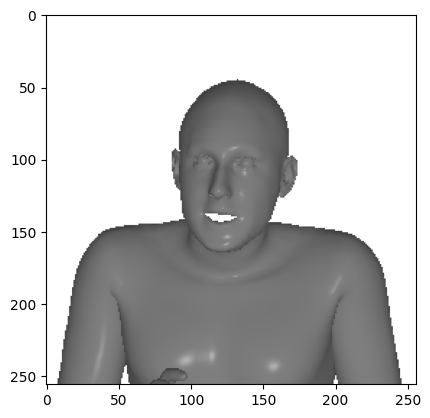

In [19]:

# device = 'cpu'
fl, pp, R, T = set_pytorch3D()

verts1, faces1, _ = load_obj("./data/jhon_oliver/meshes/00000.obj", device=device)
V = verts1.shape[0]
print(verts1[None].shape, faces1.verts_idx[None].shape)
verts_rgb = torch.from_numpy(np.array([0.5, 0.5, 0.5])).float()[None, None, :].repeat(1,V,1)
textures = TexturesVertex(verts_features=verts_rgb,).to(device)

meshes = Meshes(verts=verts1[None], faces=faces1.verts_idx[None], textures=textures,).to(device)
raster_settings = RasterizationSettings(
        image_size=256,
        faces_per_pixel=1,
        cull_backfaces=True,
        perspective_correct=True
)
lights = PointLights(
            device=device,
            location=((0.0, 0.0, 5.0),),
            ambient_color=((0.5, 0.5, 0.5),),
            diffuse_color=((0.5, 0.5, 0.5),)
        )

camera = PerspectiveCameras(focal_length=fl, 
                             principal_point=pp, 
                             R=R, 
                             T=T, 
                             image_size=256, 
                             device=device)

blend = BlendParams(background_color=(1.0, 1.0, 1.0))
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        # lights=lights,
        blend_params=blend,
    )
)

target_images = renderer(meshes, cameras=camera, lights=lights)

num_views = 1
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [camera]
from matplotlib import pyplot as plt
plt.imshow(target_rgb[0].cpu().numpy())
plt.show()

In [20]:
img = Image.open('./data/jhon_oliver/00000.png')
img = img.resize((256, 256))
img = torch.from_numpy(np.array(img)/255.)
target_rgb = [img[:,:,:3].to('cuda')]


In [22]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=None, 
                         target_image=target_rgb[0], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [26]:
# src_mesh = ico_sphere(4, device)
src_mesh = meshes.clone()

In [17]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

In [28]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 1
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([sphere_verts_rgb], lr=1.0, momentum=0.9)

100%|██████████| 2000/2000 [00:55<00:00, 36.07it/s]


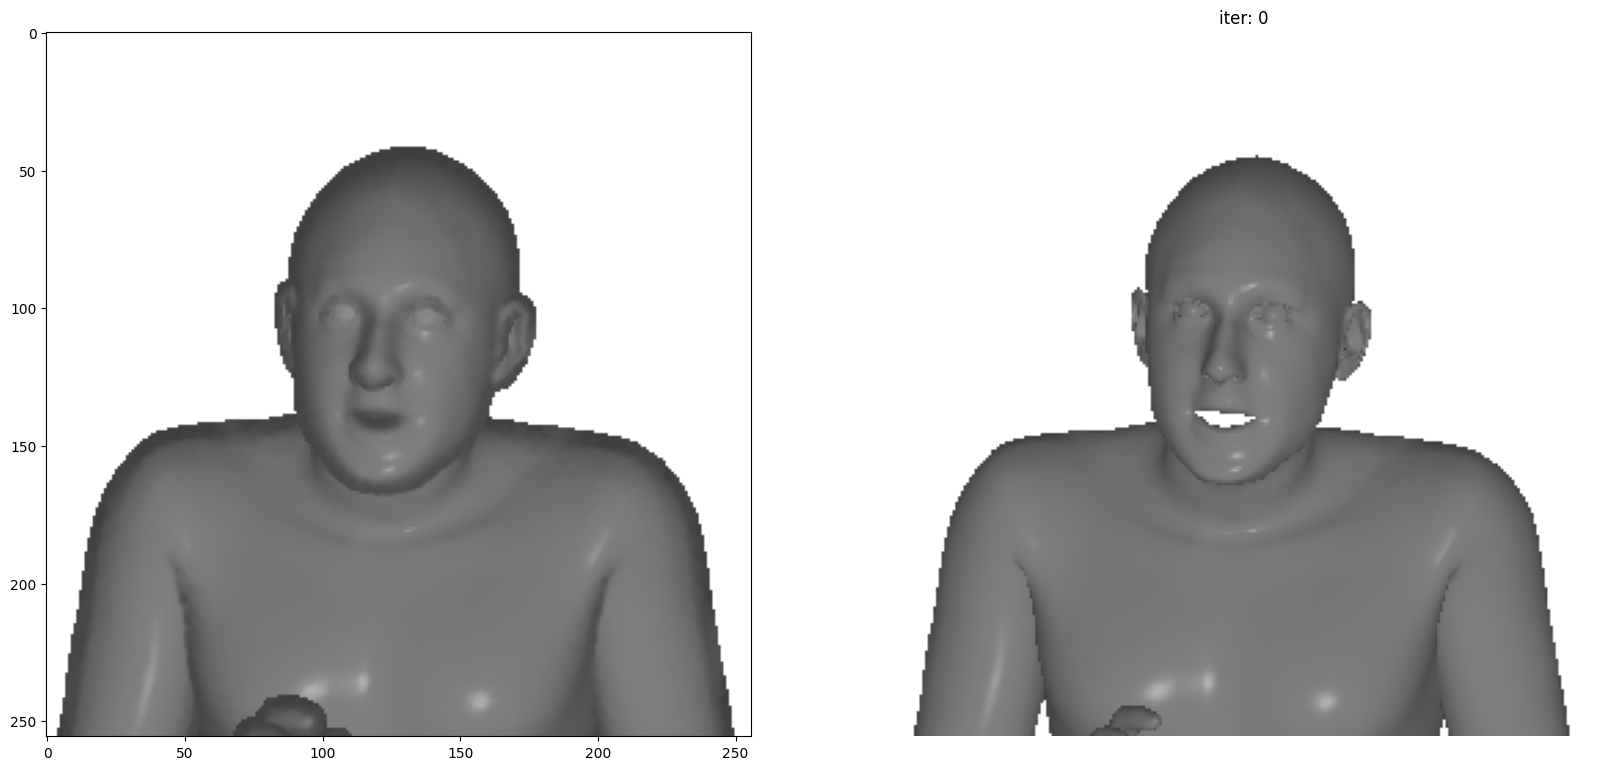

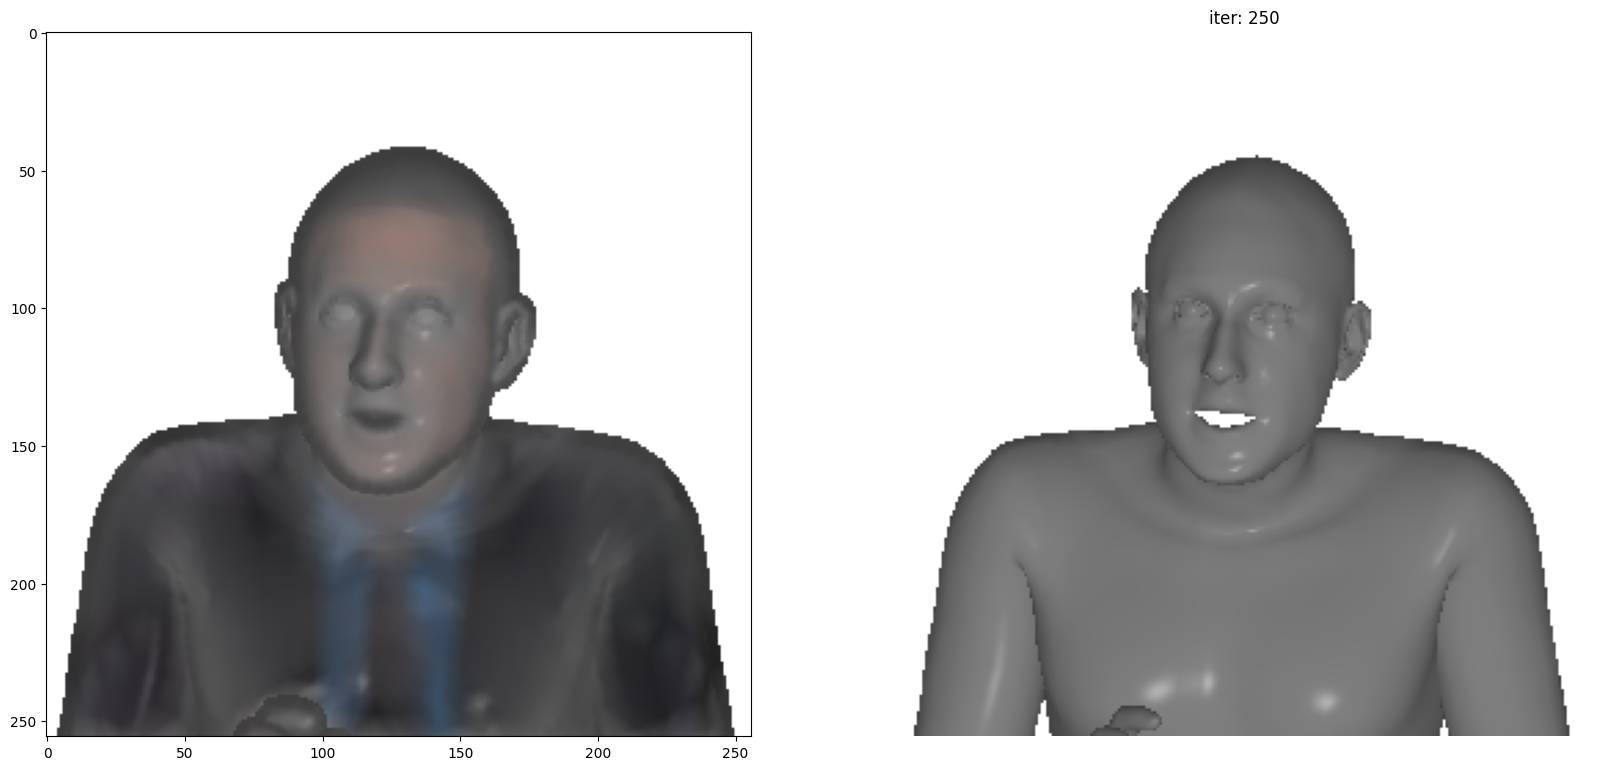

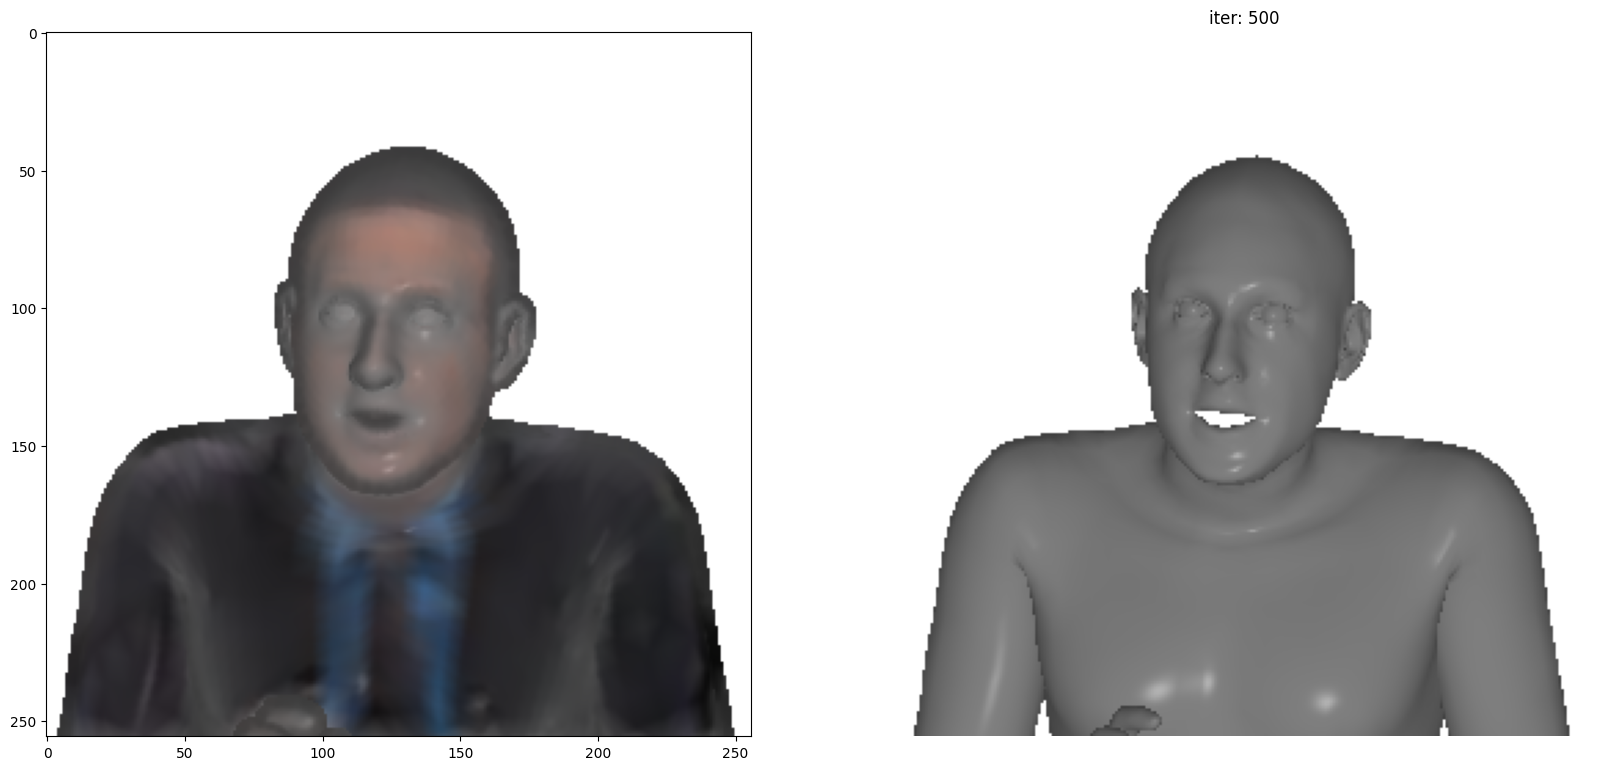

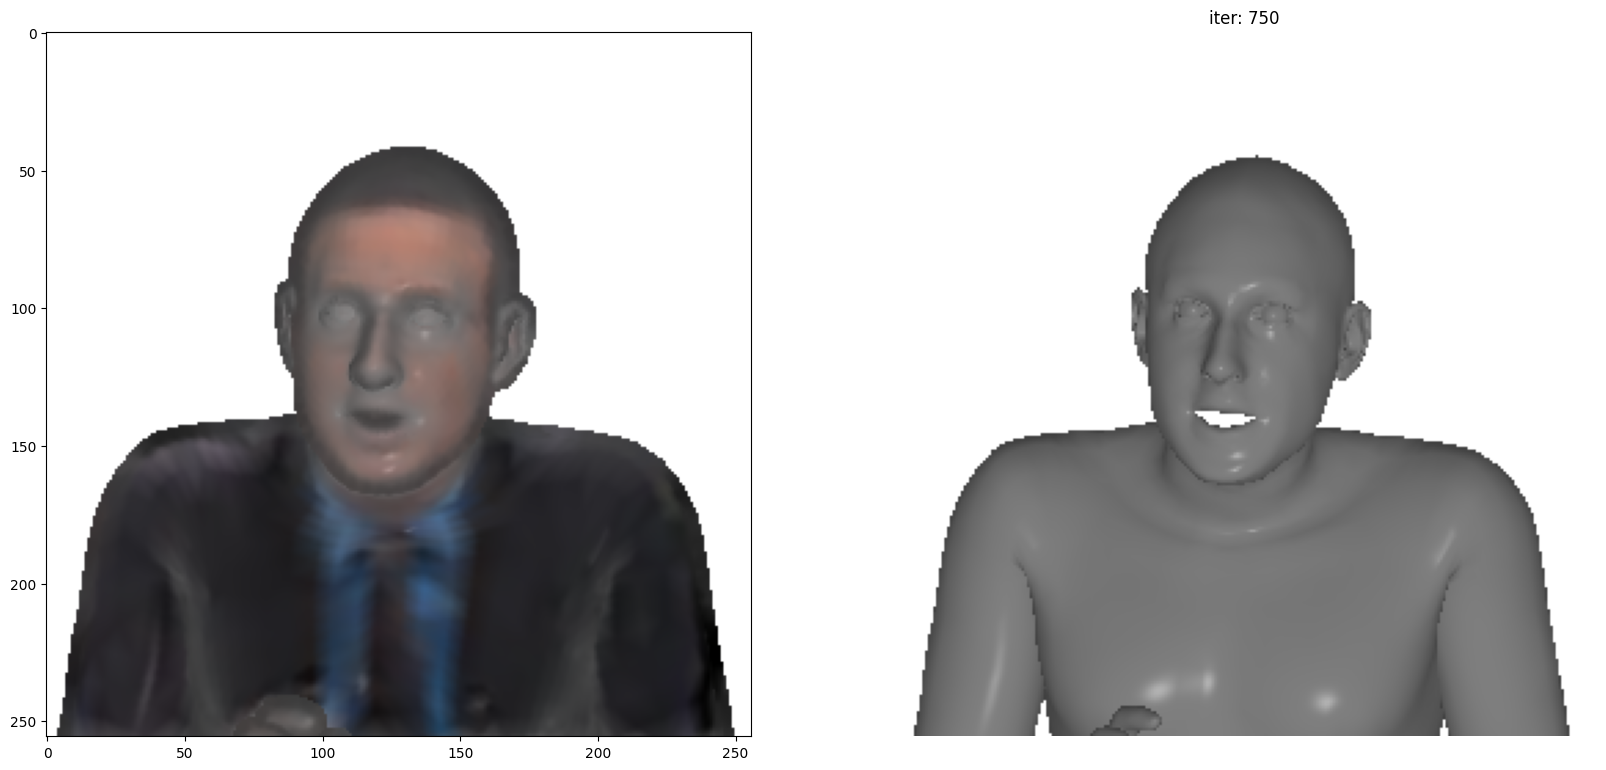

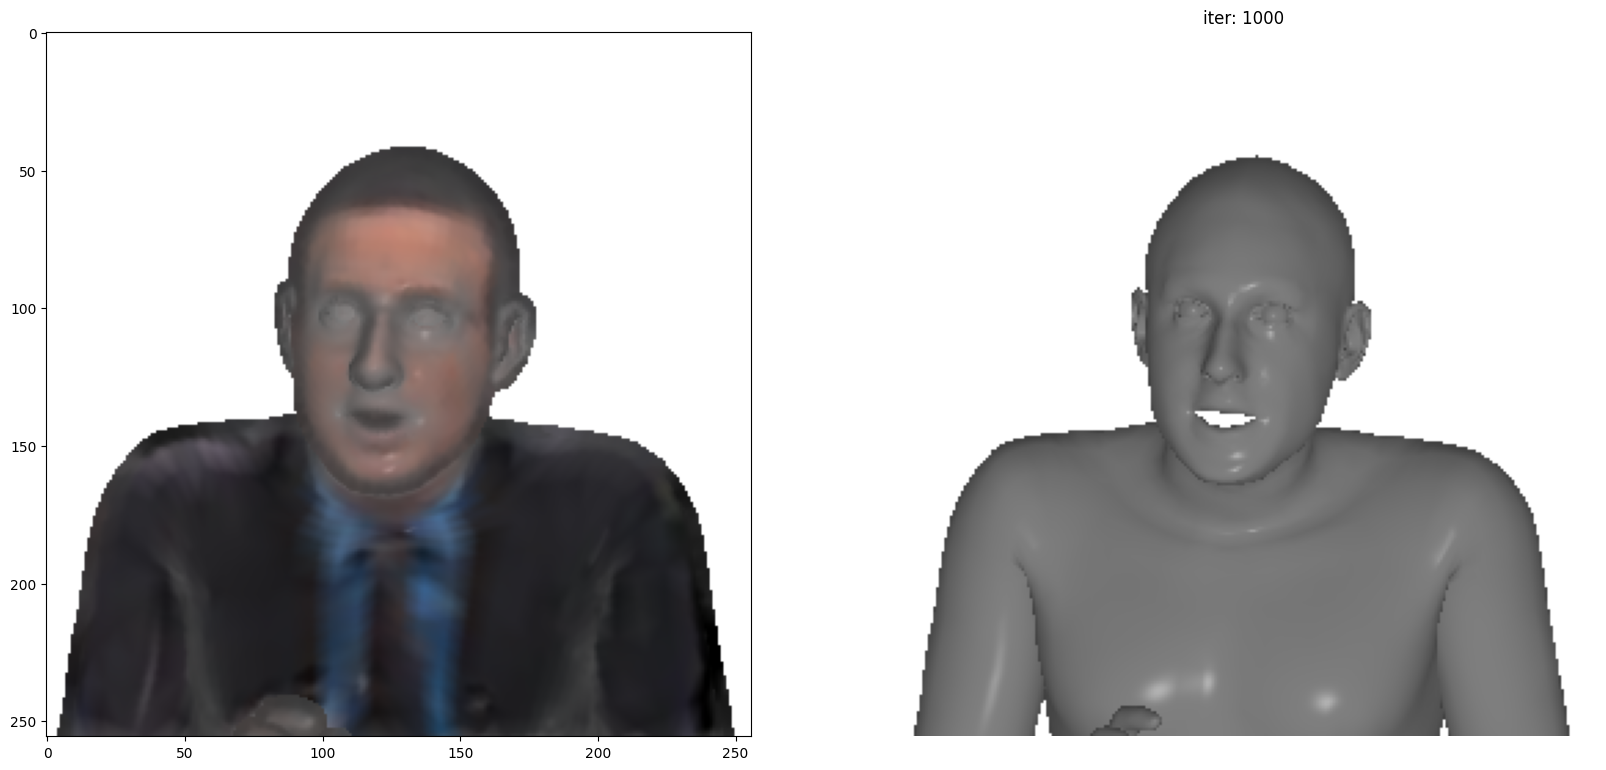

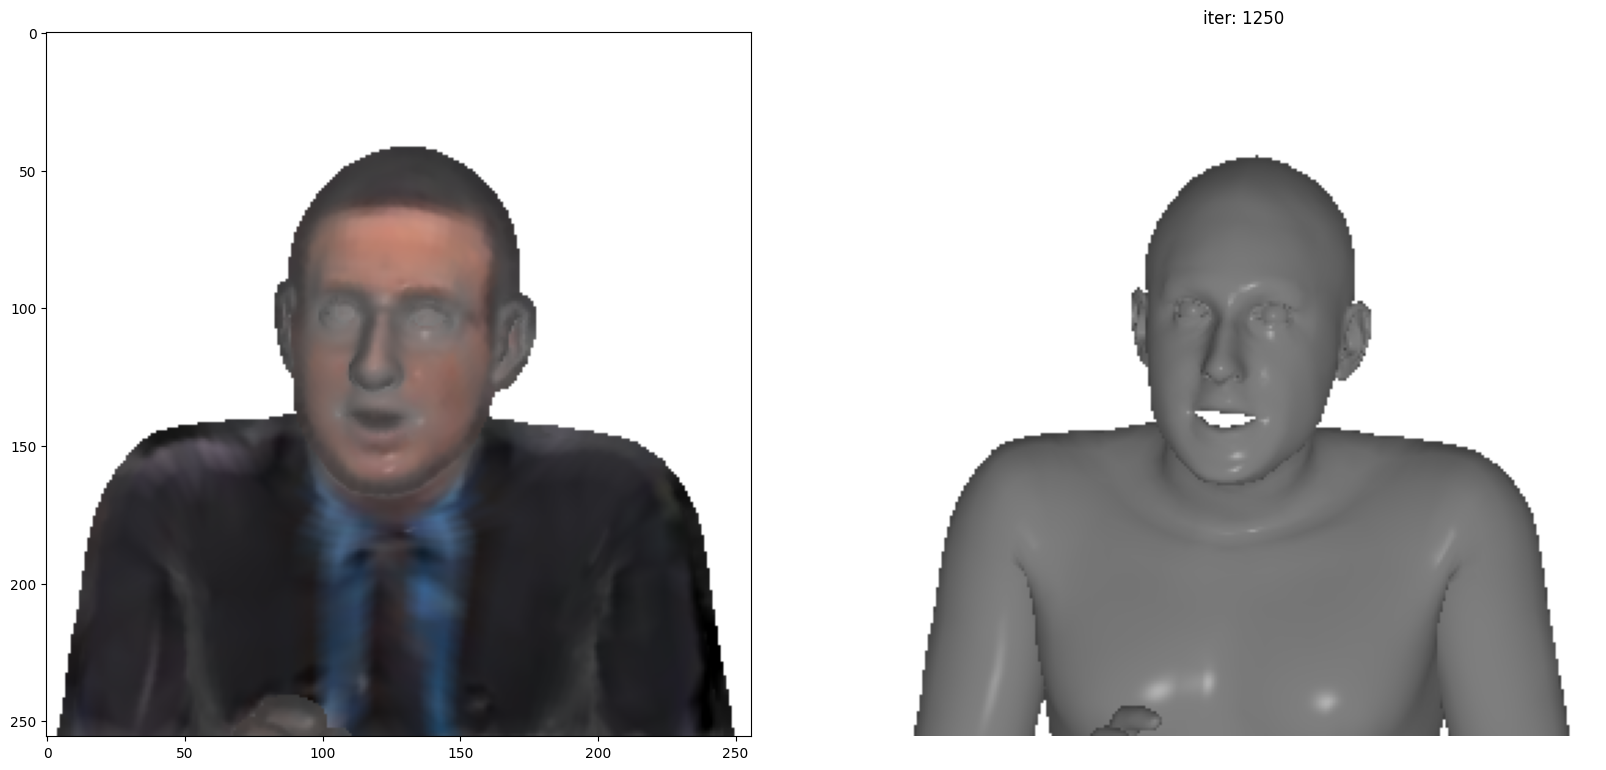

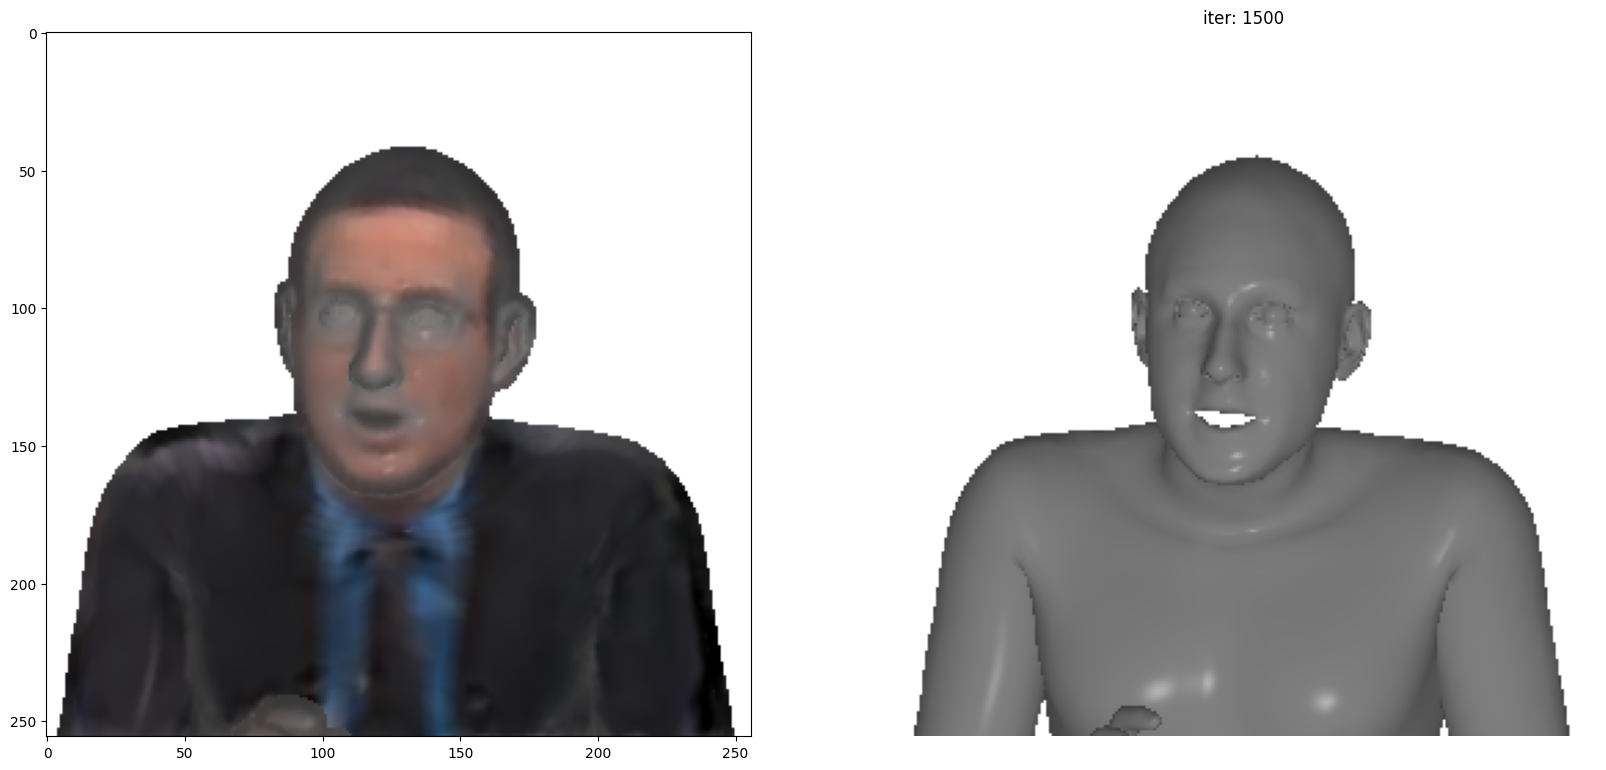

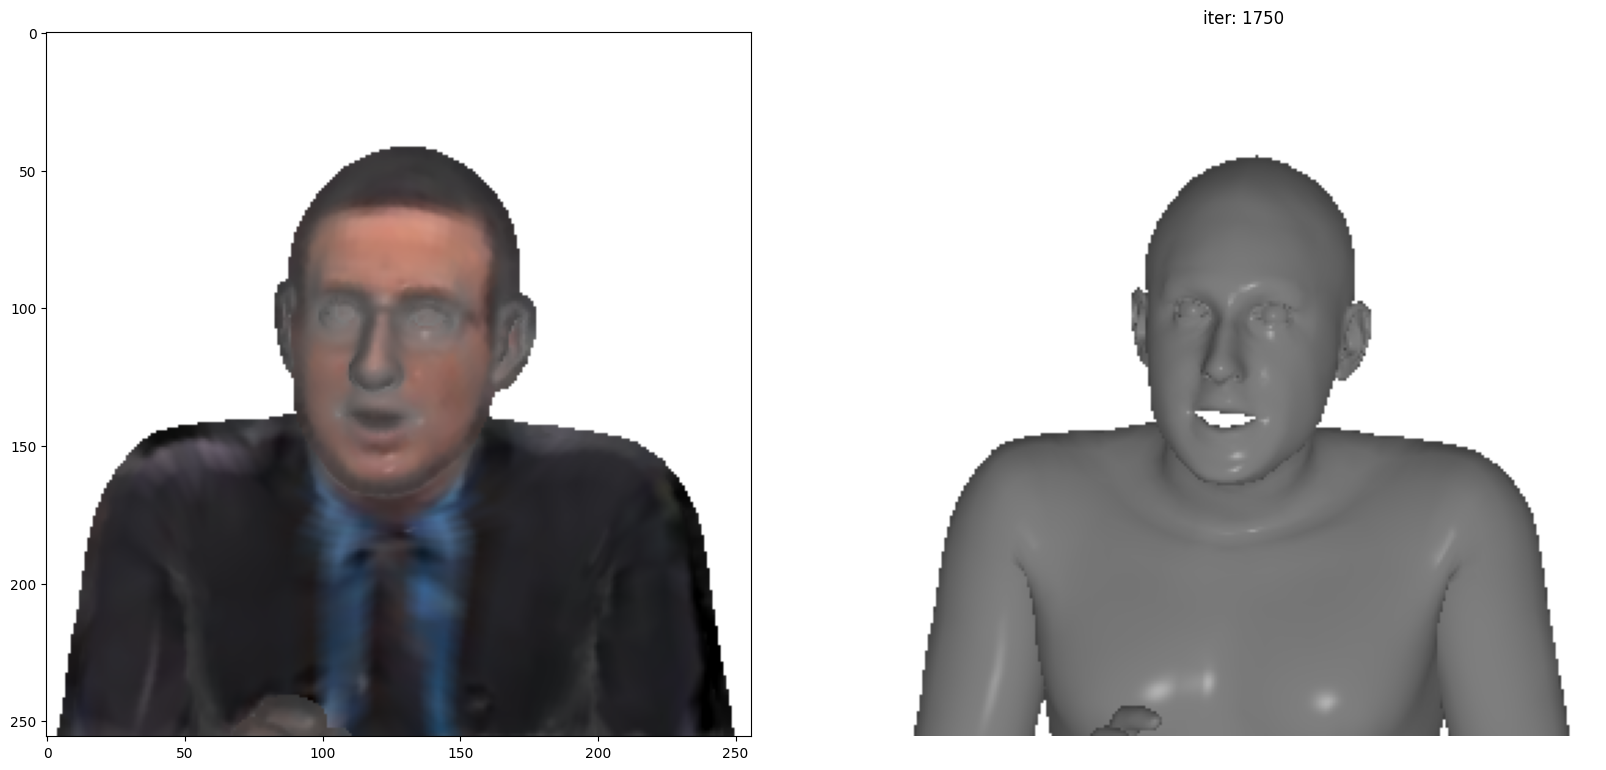

In [34]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Add per vertex colors to texture the mesh
    new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb) 
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    # update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # # Squared L2 distance between the predicted silhouette and the target 
        # # silhouette from our dataset
        # predicted_silhouette = images_predicted[..., 3]
        # loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        # loss["silhouette"] += loss_silhouette / num_views_per_iteration
        
        # Squared L2 distance between the predicted RGB image and the target 
        # image from our dataset
        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))
    
    # Print the losses
    # loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()


In [36]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)